In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string

In [2]:
df = pd.read_csv("../artifacts/extracted_files.csv")

In [3]:
import regex as re
from nltk.corpus import stopwords

In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
df

,Unnamed: 0,email,name,content,label,skills
0,0,NaN,Anubhav Kumar Singh,Anubhav Kumar Singh\t\t\r\r To work in a gl...,Peoplesoft Resume,"['Electrical', 'Unix', 'Writing', 'Installatio..."
1,1,NaN,G. Ananda,\r\r\r\r\r\r\t\r\rProfile Summary:\t\t\t\t\t\t...,Peoplesoft Resume,"['Unix', 'Installation', 'System', 'Testing', ..."
2,2,NaN,PeopleSoft Database Administrator,PeopleSoft Database Administrator\r ...,Peoplesoft Resume,"['Unix', 'Installation', 'System', 'Erp', 'Tes..."
3,3,NaN,Classification: Internal,Murali\r\rExperience Summary \r\rI have 6 year...,Peoplesoft Resume,"['Debugging', 'Unix', 'Installation', 'C', 'Sy..."
4,4,NaN,Priyanka Ramadoss,"Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...",Peoplesoft Resume,"['Unix', 'Installation', 'System', 'Banking', ..."
...,...,...,...,...,...,...
73,73,NaN,Workday Integration,\tWorkday Integration Consultant\r\rName ...,workday,"['Writing', 'Payroll', 'Agile', 'Vendors', 'Sy..."
74,74,NaN,Srikanth (WORKDAY,Seeking suitable positions in Workday HCM as ...,workday,"['Writing', 'Payroll', 'System', 'Erp', 'Testi..."
75,75,NaN,WORKDAY |,/\rWORKDAY | HCM | FCM\rName \t\t: Kumar S.S\r...,workday,"['Payroll', 'Vendors', 'System', 'Erp', 'Payme..."
76,76,NaN,Venkateswarlu.B,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,workday,"['Writing', 'Payroll', 'Vendors', 'System', 'P..."


In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [7]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


In [8]:
def preprocess_and_stem(text):
    if text.startswith("b'"):
        text = text[2:]
    cleaned_text = re.sub(r'[\n\t]', ' ', text)
    cleaned_text = cleaned_text.replace('\x07', '')
    cleaned_text = re.sub(r'(\\n|\\t|\\x07|\\\\)', ' ', cleaned_text)
    cleaned_text = re.sub(r'\'b\'|\'"', '', cleaned_text)
    cleaned_text = re.sub(r'(\\x[0-9a-fA-F]{2}|\\xc7\\x81|\\xe2\\x80\\x99)', '', cleaned_text)
    cleaned_text = re.sub(r'[\uf0b7/]', ' ', cleaned_text)
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(cleaned_text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    stemmed_text = stemmed_text.lower()

    
    return stemmed_text

In [9]:
df["clean column"] = df["content"].apply(preprocess_and_stem)

In [10]:
df["clean column"]

0     anubhav kumar singh to work global competit en...
1     profil summari 7 year experi implement upgrad ...
2     peoplesoft databas administr gangareddi profes...
3     murali experi summari i 6 year experi work peo...
4     priyanka ramadoss 61 46 mountpleas coonoor the...
                            ...                        
73    workday integr consult name sri krishna s prof...
74    seek suitabl posit workday hcm techno function...
75    workday hcm fcm name kumar ss role workday con...
76    venkateswarlub workday consult have 53 year ex...
77    vinay kumar v workday function consult experti...
Name: clean column, Length: 78, dtype: object

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
cv = CountVectorizer()
cv.fit_transform(df["clean column"]).toarray().shape

(78, 3948)

In [15]:
len(cv.vocabulary_)

3948

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score ,classification_report

In [17]:
X_train , X_test , y_train, y_test = train_test_split(df["clean column"], df['label'], test_size=0.2, random_state=0)

In [18]:
 models = {
        'Naive Bayes Multinomial': MultinomialNB(),
        'Naive Bayes Binomial': BernoulliNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(kernel='linear'),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'AdaBoost': AdaBoostClassifier(),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'XGBoost': XGBClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0)
    }

In [19]:
def text_classifier(X_train, X_test, y_train, y_test, models):  
    
    vectorizers = {
        'CountVectorizer 1-gram': CountVectorizer(ngram_range=(1, 1)),
        'CountVectorizer 2-gram': CountVectorizer(ngram_range=(1, 2)),
        'CountVectorizer 3-gram': CountVectorizer(ngram_range=(1, 3)),
        'TF-IDF 1-gram': TfidfVectorizer(ngram_range=(1, 1)),
        'TF-IDF 2-gram': TfidfVectorizer(ngram_range=(1, 2)),
        'TF-IDF 3-gram': TfidfVectorizer(ngram_range=(1, 3))
    }
    
    results = {}
    
    
    for model_name, model in models.items():
        for vectorizer_name, vectorizer in vectorizers.items():
            
            pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train, y_train)
            
            y_pred = pipeline.predict(X_test)
            y_pred_train = pipeline.predict(X_train)
            
            accuracy_test = accuracy_score(y_test, y_pred)
            precision_test = precision_score(y_test, y_pred, average='weighted', zero_division=1)
            recall_test = recall_score(y_test, y_pred, average='weighted')
            
            accuracy_train = accuracy_score(y_train, y_pred_train)
            precision_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=1)
            recall_train = recall_score(y_train, y_pred_train, average='weighted')
            
            parameters = model.get_params()
            
            results[f'{model_name} - {vectorizer_name}'] = {
                'Accuracy Test': accuracy_test,
                'Precision Test': precision_test,
                'Recall Test': recall_test,
                'Accuracy Train': accuracy_train,
                'Precision Train': precision_train,
                'Recall Train': recall_train,
                'Model Params': parameters
            }
            
    results_df = pd.DataFrame(results).T
            
    return results_df



In [ ]:
text_classifier(X_train, X_test, y_train, y_test, models=models)

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 1))),
    ('classifier', MultinomialNB())
])

param_grid = {
    'vectorizer__max_features': [1000, 2000, 3000,4000],  
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__alpha': [0.1, 0.5, 1.0],
}

In [32]:
grid_search = GridSearchCV(pipeline, param_grid, cv=8, verbose=1, n_jobs=-1, scoring='precision_macro')
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [29]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [30]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best Score: 0.9895833333333333


In [31]:
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         7

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [32]:
grid_search.best_estimator_

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('classifier', MultinomialNB(alpha=0.1))])

In [33]:
print(classification_report(grid_search.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         7

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [34]:
import pickle

In [40]:
with open("grid_search_1.pkl", "wb") as f:  
    pickle.dump(grid_search, f)

In [41]:
with open("grid_search_1.pkl", "rb") as f:  
    pickle.load(f)

<Axes: ylabel='count'>

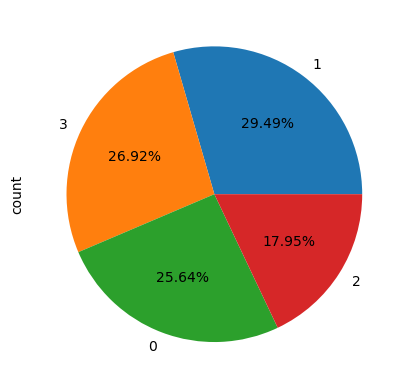

In [42]:
df["label"].value_counts().plot(kind="pie", autopct="%.2f%%")

label 
 - 3 Workday
 - 0 PeopleSoft
 - 2 SQL Developer
 - 1 React Developer

In [43]:
skills = df[df["label"] == 3]["skills"]

In [44]:
import ast
df["skills"] = df["skills"].apply(ast.literal_eval)

In [45]:
skills

57    ['Writing', 'Payroll', 'Prototyping', 'System'...
58    ['Writing', 'Payroll', 'System', 'Testing', 'P...
59    ['Unix', 'Payroll', 'Prototyping', 'Software e...
60    ['Debugging', 'Unix', 'Payroll', 'Vendors', 'P...
61    ['Staffing', 'Process', 'Queries', 'Matrix', '...
62    ['Payroll', 'Vendors', 'Html', 'Erp', 'Program...
63    ['Payroll', 'System', 'Erp', 'Testing', 'Payme...
64    ['System', 'Testing', 'Mechanical engineering'...
65    ['Debugging', 'Writing', 'Payroll', 'System', ...
66    ['Payroll', 'Vendors', 'System', 'Testing', 'P...
67    ['Writing', 'Payroll', 'Emea', 'System', 'Test...
68    ['Writing', 'Powerpoint', 'System', 'Erp', 'Ex...
69    ['Schedules', 'Payroll', 'Programming', 'Testi...
70    ['Writing', 'Payroll', 'Vendors', 'System', 'E...
71    ['Schedules', 'Writing', 'System', 'Erp', 'Tes...
72    ['Social media', 'Payroll', 'Vendors', 'Data e...
73    ['Writing', 'Payroll', 'Agile', 'Vendors', 'Sy...
74    ['Writing', 'Payroll', 'System', 'Erp', 'T

In [46]:
from collections import Counter

all_skills = [skill for sublist in df[df["label"] == 0]["skills"] for skill in sublist]
skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(20)

In [47]:
[skill[0] for skill in top_skills]

['Peoplesoft',
 'Process',
 'Oracle',
 'Reports',
 'System',
 'Testing',
 'Database',
 'Technical',
 'Windows',
 'Sql',
 'Security',
 'Architecture',
 'Administration',
 'Servers',
 'Unix',
 'Installation',
 'Troubleshooting',
 'Tax',
 'Finance',
 'Migration']

In [48]:
df = df.drop(columns =["Unnamed: 0", "email", "name"])

In [ ]:
df.to_csv("final_df.csv")

In [22]:
import sklearn
print(sklearn.__version__)

1.5.0


In [1]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pandas 
print(pandas.__version__)

2.2.2


In [4]:
import numpy 
print(numpy.__version__)

1.24.3


In [ ]:
d